[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Multivariate Gaussians  - Modeling Uncertainty in Multiple Dimensions

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import sys
sys.path.insert(0,'./code')
from book_format import load_style
load_style()

## Introduction

The techniques in the last chapter are very powerful, but they only work with one variable or dimension. Gaussians represent a mean and variance that are scalars - real numbers. They provide no way to represent multidimensional data, such as the position of a dog in a field. You may retort that you could use two Kalman filters from the last chapter. One would track the x coordinate and the other  the y coordinate. That does work, but suppose we want to track position, velocity, acceleration, and attitude. These values are related to each other, and as we learned in the g-h chapter we should never throw away information. Through one key insight we will achieve markedly better filter performance than was possible with the equations from the last chapter.

In this chapter I will introduce you to multivariate Gaussians - Gaussians for more than one variable, and the key insight I mention above. Then, in the next chapter we will use the math from this chapter to write a complete filter in just a few lines of code. 

## Multivariate Normal Distributions

In the last two chapters we used Gaussians for a scalar (one dimensional) variable, expressed as $\mathcal{N}(\mu, \sigma^2)$. A more formal term for this is *univariate normal*, where univariate means 'one variable'. The probability distribution of the Gaussian is known as the *univariate normal distribution*.

What might a *multivariate normal distribution* be? *Multivariate* means multiple variables. Our goal is to be able to represent a normal distribution across multiple dimensions. I don't necessarily mean spatial dimensions - it could be position, velocity, and acceleration. Consider a two dimensional case. Let's say we believe that $x = 2$ and $y = 17$. This might be the *x* and *y* coordinates for the position of our dog, it might be the  position and velocity of our dog on the x-axis, or the temperature and wind speed at our weather station. It doesn't really matter. We can see that for $N$ dimensions, we need $N$ means, which we will arrange in a column matrix (vector) like so:

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

Therefore for this example we would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incomplete because it does not consider the more general case. For example, suppose we were tracking house prices vs total $m^2$ of the floor plan. These numbers are *correlated*. It is not an exact correlation, but in general houses in the same neighborhood are more expensive if they have a larger floor plan. We want a way to express not only what we think the variance is in the price and the $m^2$, but also the degree to which they are correlated. The *covariance* describes how two variables are correlated. Covariance is short for *correlated variances*.

 In other words, covariance is a measure for how much variables change together. A couple of examples. Generally speaking as the square footage of a house increases the price increases. These variables are *correlated*, which is also sometimes called *positively correlated*. As the temperature of an automobile's engine increases its life expectancy lowers. These are *inversely correlated* because as one variable gets larger the other variable lowers. This is also called *negatively correlated*. The price of tea and the number of tail wags my dog makes have no relation to each other, and we say they are not correlated - each can change independent of the other.

Correlation implies *prediction*. If our houses are in the same neighborhood, and yours has twice the square footage of my house I can predict that your house has a higher market price than mine. This is not guaranteed as there are other factors such as proximity to garbage dumps which also affect the price. If my car engine significantly overheats I start planning on replacing it soon. If my dog wags his tail more I don't conclude that tea prices will be increasing.

For example, here is a plot of of floor plan size vs price for a neighborhood. If a new house comes on the market with a floor plan size of 225 $m^2$ we can estimate its price to be somewhere around $425,000. The correspondence between floor plan area and price is not perfect, but clearly there is enough correlation between them for us to make a reasonable prediction.

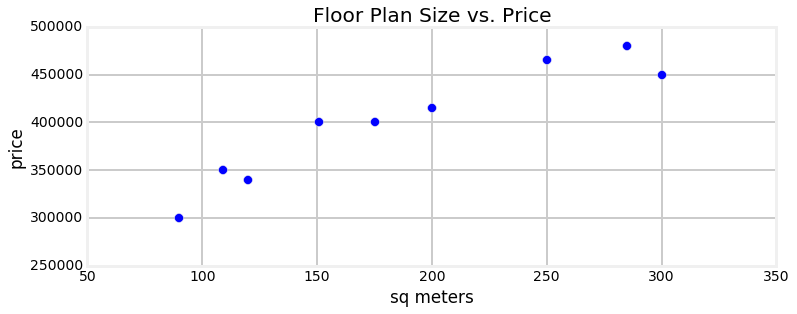

In [45]:
import matplotlib.pyplot as plt
area = [90, 109, 120, 151, 175, 200, 250, 285, 300]
price = [300000, 350000, 340000, 400000, 400000, 415000, 465000, 480000, 450000]
plt.scatter(area, price, s=80)
plt.title('Floor Plan Area vs. Price')
plt.xlabel('sq meters'); plt.ylabel('price')
plt.show()

We use a *covariance matrix* to denote covariances of a multivariate normal distribution, and it looks like this:
$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

If you haven't seen this before it is probably a bit confusing. Instead of starting with the mathematical definition I will build your intuition with thought experiments. At this point, note that the diagonal contains the variance for each variable, and that all off-diagonal elements (covariances) represent how much the $i$th (horizontal row) and $j$th (vertical column) variables are linearly correlated to each other. So $\sigma_3^2$ is the variance of the third variable, and $\sigma_{13}$ is the covariance between the first and third variables.

A covariance of 0 indicates no correlation. So, for example, if the variance for x is 10, the variance for y is 4, and there is no linear correlation between x and y, then we would write

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of correlation between x and y we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between x and y. Note that this is always symmetric - the covariance between x and y is always equal to the covariance between y and x. That is, $\sigma_{xy}=\sigma_{yx}$ for any x and y.

Now, without explanation, here is the multivariate normal distribution in $n$ dimensions.

$$
f(\mathbf{x},\, \mu,\,\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\, \exp  \Big [{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) \Big ]}
$$

I urge you to not try to remember this equation. We will program it in a Python function and then call it if we need to compute a specific value. Plus, the Kalman filter equations compute this for us automatically; we never have to explicitly compute it. However, note that it has the same form as the univariate normal distribution. It uses matrices instead of scalar values, and the root of $\pi$ is scaled by $n$. If you set n=1 then it turns into the univarate equation. Here is the univariate equation for reference:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp \Big [{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 \Big ]
$$

The multivariate version merely replaces the scalars of the univariate equations with matrices. If you are reasonably well-versed in linear algebra this equation should look quite manageable; if not, don't worry! Let's plot it and see what it looks like.

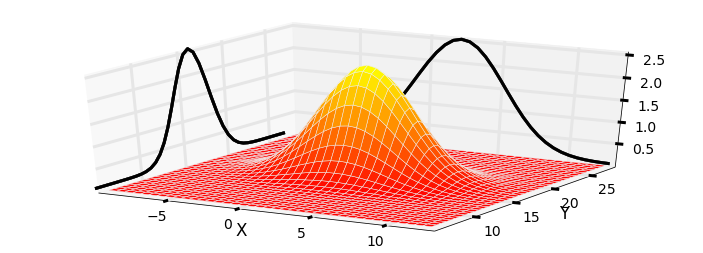

In [3]:
import mkf_internal
mkf_internal.plot_3d_covariance((2, 17), [[10., 0], [0, 4.]])

This is a plot of two dimensional multivariate Gaussian with a mean of $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ and a covariance of $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$. The three dimensional shape shows the probability density of for any value of (x,y) in the z-axis. I have projected the variance for x and y onto the walls of the chart - you can see that they take on the normal Gaussian bell curve shape. The curve for x is wider than the curve for y, which is explained by $\sigma_x^2=10$ and $\sigma_y^2=4$. The highest point of the curve is centered over (2, 17), the means for x and y. 

All multivariate Gaussians have this shape. If we think of this as a the Gaussian for the position of a dog, the z-value at each point of (x, y) is the probability density of it being at that position. Strictly speaking this is the *joint probability density function*, which I will define soon. So, he has the highest probability of being near (2, 17), a modest probability of being near (5, 14), and a very low probability of being near (10, 10). As with the univariate case this is a *probability density*, not a *probability*. Continuous distributions have an infinite range, and so the probability of being exactly at (2, 17), or any point, is 0%. We can compute the probability of being within a given range by computing the area under the curve. 

For now we need to understand the following:

1. The diagonal of the matrix contains the variance for each variable. This is because the covariance between x and itself is the variance of x: $\sigma_{xx} = \sigma_x^2$.


2. Each off-diagonal element contains $\sigma_{ij}$ - the covariance between *i* and *j*. This tells us how much linear correlation there is between the two variables. 0 means no correlation, and as the number gets higher the correlation gets greater.

3. $\sigma_{ij} = \sigma_{ji}$: if i gets larger when j gets larger, then it must be true that j gets larger when i gets larger.

4. This chart only shows a 2 dimensional Gaussian, but the equation works for any number of dimensions > 0.

FilterPy [2] implements the equation with the function `filterpy.stats.multivariate_gaussian`. I am not showing the code here because I have taken advantage of the linear algebra solving apparatus of NumPy to efficiently compute a solution - the code does not correspond to the equation in a one to one manner.

In the last chapter we did not have to explicitly program the univariate equation into our filter. The filter equations were generated by substituting the univariate equation into Bayes' equation. The same is true for the multivariate case. You will not be using this function very often in this book, so I would not spend a lot of time mastering it unless it interests you.

SciPy's `stats` module implements the multivariate normal equation with `multivariate_normal()`. It implements a 'frozen' form where you set the mean and covariance once, and then calculate the probability for any number of values for x over any arbitrary number of calls. This is much more efficient then recomputing everything in each call. So, if you have version 0.14 or later you may want to substitute my function for the built in version. Use `scipy.version.version` to get the version number. I named my function `multivariate_gaussian()` to ensure it is never confused with the SciPy version. I will say that for a single call, where the frozen variables do not matter, mine consistently runs faster as measured by the `timeit` function.

> The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">tutorial</a>[1] for the `scipy.stats` module explains 'freezing' distributions and other very useful features.

In [4]:
from filterpy.stats import gaussian, multivariate_gaussian

I'll demonstrate using it, and then move on to more interesting things.

First, let's find the probability density for our dog being at (2.5, 7.3) if we believe he is at (2, 7) with a variance of 8 for $x$ and a variance of 3 for $y$.

Start by setting $x$ to (2.5, 7.3). You can use a tuple, list, or NumPy array.

In [5]:
x = [2.5, 7.3]

Next, we set the mean of our belief:

In [6]:
mu = [2.0, 7.0]

Finally, we have to define our covariance matrix. In the problem statement we did not mention any correlation between $x$ and $y$, and we will assume there is none. This makes sense; a dog can choose to independently wander in either the $x$ direction or $y$ direction without affecting the other. If there is no correlation between the values place the variances in the diagonal, and set off-diagonal elements to zero. I will use name `P`. Kalman filters use the name $\textbf{P}$ for the covariance matrix, and we need to become familiar with the conventions.

In [7]:
P = [[8., 0.], 
     [0., 3.]]

Now call the function

In [8]:
print('{:.4}'.format(multivariate_gaussian(x, mu, P)))

0.03151


These numbers are not easy to interpret. Let's view a plot of it.

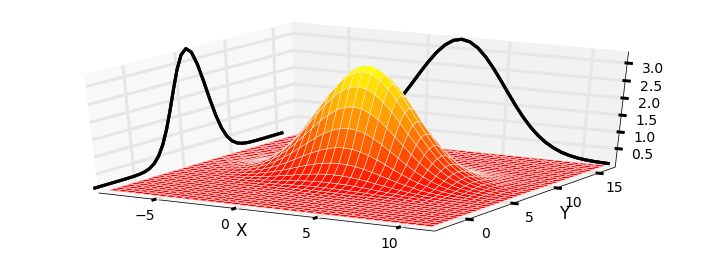

In [9]:
import mkf_internal
import matplotlib.pyplot as plt

ax = mkf_internal.plot_3d_covariance(mu, P)

The result is clearly a 3D bell shaped curve. We can see that the Gaussian is centered around (2,7), and that the probability density quickly drops away in all directions. This plot shows what is known as the *joint probability*. On the sides of the plot I have drawn the *marginal probability* for $x$ and $y$.

It's time to define some terms. The *joint probability*, denoted $p(x,y)$, is the probability of both $x$ and $y$ happening simultaneously.  For example, if you have two die $p(2,5)$ is the probability of the first die rolling a 2 and the second die rolling a 5. Assuming the die are six sided and fair, the probability $p(2,5) = \frac{1}{6}\times \frac{1}{6}=\frac{1}{36}$. The 3D chart above shows the *joint probability density function*. This means that the area under the curve at any location is proportional to probability of the dog being in that $(x, y)$ position.

The *marginal probability* is the probability of an event happening without regard of any other event. In the chart above the Gaussian curve drawn to the left is the marginal for $y$. This is the probability for the dog being at any position in $y$ disregarding the value for $x$. In back I've plotted the marginal for $x$, which is the probability of the dog being at any position in $x$ disregarding $y$.

Let's look at this in a slightly different way. Instead of plotting a surface showing the probability distribution I will generate 1,000 points with the distribution of $[\begin{smallmatrix}8&0\\0&3\end{smallmatrix}]$.

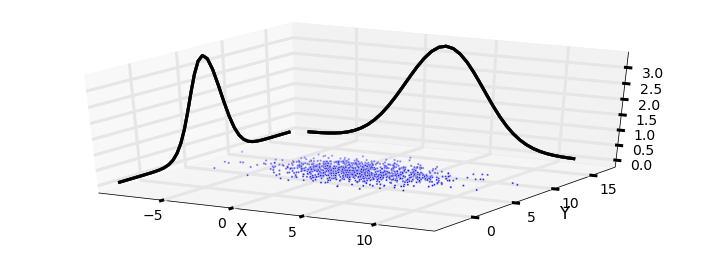

In [10]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

We can think of the sampled points as being possible locations for our dog given those particular mean and covariances. The contours on the side show the marginal probability for $x$ and $y$. We can see that he is far more likely to be at (2, 7) where there are many points, than at (-5, 5) where there are few.

As beautiful as this is, it is hard to get useful information. For example, it is not easy to tell if $x$ and $y$ both have the same variance. In most of the book I'll display Gaussians using contour plots. Helper functions in FilterPy plot them for us. If you are interested in linear algebra look at the code used to produce these contours, otherwise feel free to ignore it. 

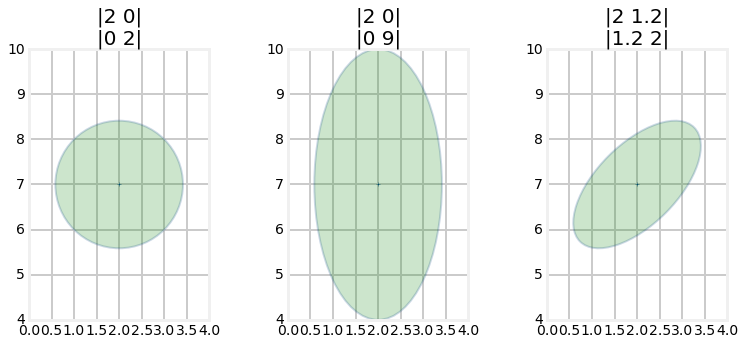

In [11]:
from book_format import set_figsize, figsize

with figsize(y=5):
    mkf_internal.plot_3_covariances()

For those of you viewing this online or in IPython Notebook on your computer, here is an animation.
<img src='animations/multivariate_ellipse.gif'>

(source: http://git.io/vqxLS)

From a mathematical perspective these display the values that the multivariate Gaussian takes for a specific standard deviation. This is like taking a horizontal slice out of the 3D plot. By default it displays one standard deviation, but you can use the `variance` parameter to control what is displayed. For example, `variance=3**2` would display the 3rd standard deviation, and `variance=[1,4,9]` would display the 1st, 2nd, and 3rd standard deviations as in the chart below. This takes 3 different horizontal slices of the multivariate Gaussian chart and displays them in 2D.

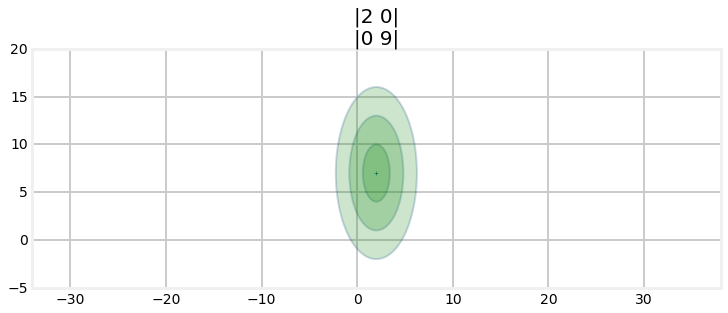

In [12]:
from filterpy.stats import plot_covariance_ellipse
P = [[2, 0], [0, 9]]
plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                        variance=[1, 2**2, 3**2],
                        axis_equal=True, title='|2 0|\n|0 9|')

However, the solid colors may suggest that the probability distribution is constant between the standard deviations. This is not true, as you can tell from the 3D plot of the Gaussian. Here is a 2D shaded representation of the probability distribution for the covariance ($\begin{smallmatrix}2&1.2\\1.2&1.3\end{smallmatrix})$.

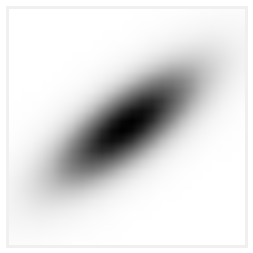

In [13]:
from nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 1.2], [1.2, 1.3]])

Thinking about the physical interpretation of these plots clarifies their meaning. The mean and covariance of the first plot is

$$
\mathbf{\mu} =\begin{bmatrix}2\\7\end{bmatrix},\, \,
\Sigma = \begin{bmatrix}2&0\\0&2 \end{bmatrix}
$$ 

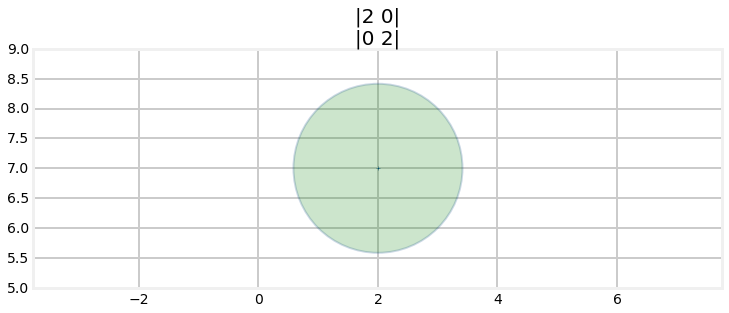

In [14]:
x = [2, 7]
P = [[2, 0], [0, 2]]
plot_covariance_ellipse(x, P, facecolor='g', alpha=0.2, 
                        title='|2 0|\n|0 2|')

Let this be our current belief about the position of our dog in a field. In other words, we believe that he is positioned at (2,7) with a variance of $\sigma^2=2$ for both x and y. The contour plot shows where we believe the dog is located with the '+' in the center of the ellipse. The ellipse shows the boundary for $1\sigma$. As in the univariate case 68% of the data will fall within this ellipse. Recall from the Gaussians chapter the the 68-95-99.7 rule - 68% of all values will fall within 1 standard deviation ($1\sigma$), 95% within $2\sigma$, and 99.7% within $3\sigma$. This rule applies for any dimensional size. The dog could be at (356443, 58483), but the chances for values that far away from the mean are infinitesimally small.

A Bayesian way of thinking about this is that the ellipse shows us the amount of error in our belief. A tiny circle would indicate that we have a very small error, and a very large circle indicates a lot of error in our belief. We will use this throughout the rest of the book to display and evaluate the accuracy of our filters at any point in time. 

The second plot is for the mean and covariance

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&0\\0&9\end{bmatrix}
$$

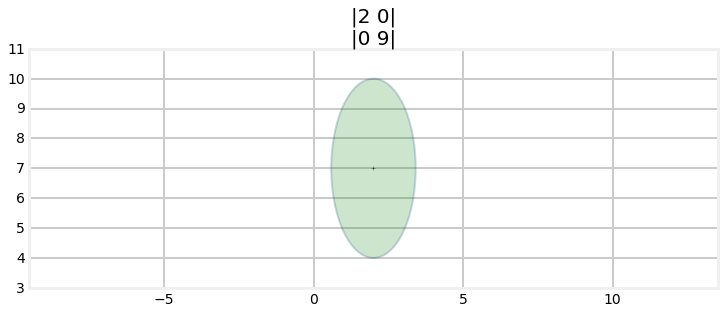

In [15]:
x = [2, 7]
P = [[2, 0], [0, 9]]
plot_covariance_ellipse(x, P, facecolor='g', alpha=0.2, 
                        title='|2 0|\n|0 9|')

This time we use a different variance for $x$ ($\sigma_x^2=2$) vs $y$ ($\sigma^2_y=9$). The result is a tall and narrow ellipse. We can see that a lot more uncertainty in $y$ value vs $x$. Our belief that the value is (2, 7) is the same in both cases, but the uncertainties are different. In this case the standard deviation in $x$ is $\sigma_x = \sqrt{2}=1.414$ and the standard deviation for $y$ is $\sigma_y = \sqrt{9}=3$. This sort of thing happens naturally as we track objects in the world - one sensor has a better view of the object or is closer than another sensor, resulting in different uncertainties in each axis.

The third plot shows the mean and covariance

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
$$

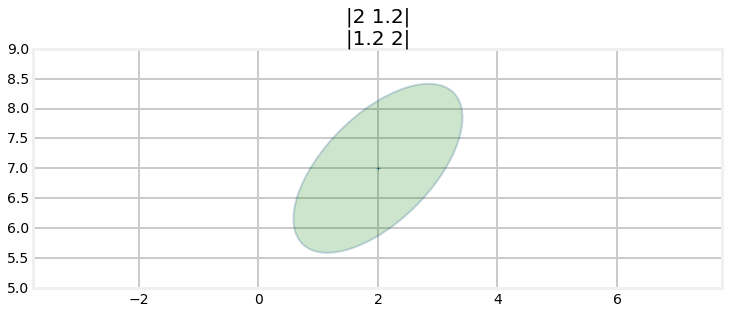

In [16]:
x = [2, 7]
P = [[2, 1.2], [1.2, 2]]
plot_covariance_ellipse(x, P, facecolor='g', alpha=0.2, 
                        title='|2 1.2|\n|1.2 2|')

This is the first contour that has values in the off-diagonal elements of the covariance, and this is the first contour plot with a slanted ellipse. This is not a coincidence. The two facts are telling us the same thing. A slanted ellipse tells us that the $x$ and $y$ values are somehow correlated. We denote that in the covariance matrix with values off the diagonal.

Recall the plot for house price vs floor plan area. The plot of price vs area form a slanted grouping of points. We can use NumPy's `cov()` function to compute the covariance of two or more variables by placing them into a 2D array. Let's do that, then plot the covariance ellipse on top of the house data plot.

In [17]:
import numpy as np
cov_house = np.cov(np.vstack((area, price)))
cov_house

array([[  2.23611111e+02,   8.80625000e+05],
       [  8.80625000e+05,   3.68125000e+09]])

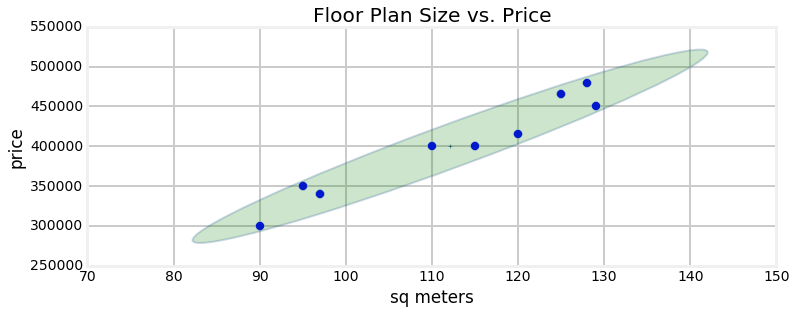

In [18]:
plt.scatter(area, price, s=80)
plt.title('Floor Plan Size vs. Price')
plt.xlabel('sq meters'); plt.ylabel('price')
plot_covariance_ellipse((np.mean(area), np.mean(price)), cov_house, fc='g', 
                        alpha=0.2, axis_equal=False, variance=[4])

This should help you form a strong intuition on the meaning and use of covariances. The covariance ellipse shows you how the data is 'scattered' in relation to each other. A narrow ellipse like this tells you that the data is very correlated. There is only a narrow range of prices for any given area. The ellipse leans towards the right, telling us there is a positive correlation - as x increases y also increases. If the ellipse leaned towards the left then the correlation would be negative - as x increases y decreases. We can see this in the following plot:

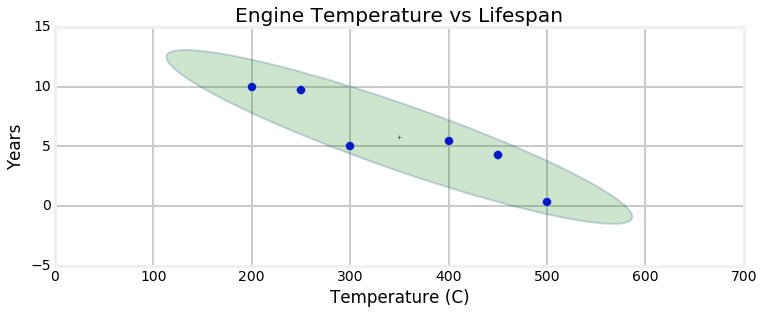

In [19]:
max_temp = [200, 250, 300, 400, 450, 500]
lifespan = [10, 9.7, 5, 5.4, 4.3, 0.3]
plt.scatter(max_temp, lifespan, s=80)
cov = np.cov(np.vstack((max_temp, lifespan)))
plot_covariance_ellipse((np.mean(max_temp), np.mean(lifespan)), cov, fc='g', 
            alpha=0.2, axis_equal=False, variance=[4])
plt.title('Engine Temperature vs Lifespan')
plt.xlabel('Temperature (C)'); plt.ylabel('Years');

 When we see this ellipse we know that $x$ and $y$ are correlated, and that the correlation is "strong". The size of the ellipse shows how much error we have in each axis, and the slant shows how the relative sizes of the variance in $x$ and $y$. For example, a very long and narrow ellipse tilted almost to the horizontal has a strong correlation between $x$ and $y$ (because the ellipse is narrow), and the variance of $x$ is much larger than that of $y$ (because the ellipse is much longer in $x$). Note that in this plot the scales of the x-axis and y-axis are not identical, so the appearence of the plot can be deceiving.

### Pearson's Correlation Coefficient

The correlation between two variables can be given a numerical value with *Pearson's Correlation Coefficient*. It is defined as

$$\rho_{xy} = \frac{cov(X, Y)}{\sigma_x \sigma_y}$$

This value can range in value from -1 to 1. If the covariance is 0 than $\rho=0$. A value greater than 0 indicates that the relationship is a positive correlation, and a negative value indicates that there is a negative correlation. Values near -1 or 1 indicate a very strong correlation, and values near 0 indicate a very weak correlation.

We can use `scipy.stats.pearsonr` function to compute the Pearson coefficient. It returns a tuple of the Pearson coefficient and of the 2 tailed p-value. The latter is not used in this book. Here we compute $\rho$ for the house price vs area:

In [20]:
from scipy.stats import pearsonr
pearsonr(area, price)[0]

0.97061425335184115

Here we compute the correlation between engine temperature and lifespan.

In [21]:
pearsonr(max_temp, lifespan)[0]

-0.91782234535272555

## Using Correlations to Improve Estimates

Suppose we believe our dog is at position (5, 10) with some given covariance. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, the covariance contour would look something like this.

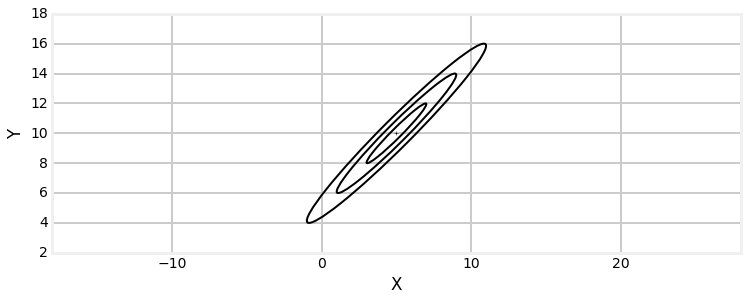

In [22]:
P = [[4, 3.9], [3.9, 4]]
plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                        variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y');

Now suppose I were to tell you that the actual position of the dog in the x-axis is 7.5, what can we infer about his position in the y-axis? The position is extremely likely to lie within the 3$\sigma$ covariance ellipse. We can *infer* the position in *y* based on the covariance matrix because there is a correlation between *x* and *y*. I've roughly illustrated the likely value for y as a blue filled circle.

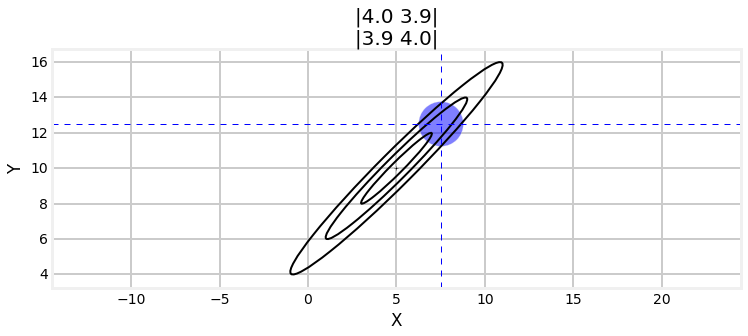

In [23]:
mkf_internal.plot_correlation_covariance()

A word about *correlation* and *independence*. If variables are *independent* they can vary separately. If you walk in an open field, you can move in the $x$ direction (east-west), the $y$ direction(north-south), or any combination thereof. Independent variables are always also *uncorrelated*. Except in special cases, the reverse does not hold true. Variables can be uncorrelated, but dependent. For example, consider the pair$(x,y)$ where $y=x^2$. Correlation is a linear measurement, so $x$ and $y$ are uncorrelated. However, they are obviously dependent on each other. 

## Multiplying Multidimensional Gaussians

In the previous chapter we incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two pieces of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

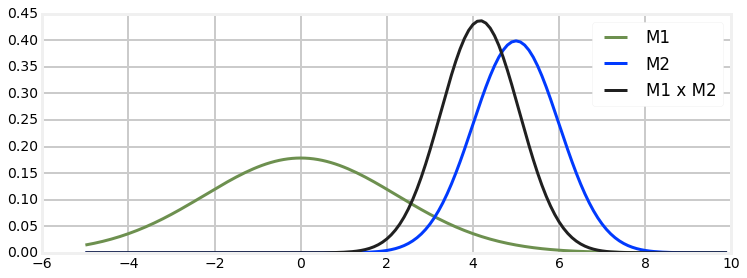

In [24]:
mkf_internal.plot_gaussian_multiply()

The combination of measurement 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. They are generated by plugging the Gaussians for the prior and the estimate into Bayes Theorem. I gave you the algebra for the univariate case in the last section of the last chapter. You will not need to remember these equations, as they are computed by Kalman filter equations that will be presented shortly. This computation is also available in FilterPy using the `multivariate_multiply()` method, which you can import from `filterpy.stats`. 

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}} = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* division since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do but it does help us see what is going on.

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form we can surmise that these equations are the linear algebra form of the univariate equations.

Now let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with two radar systems. I will ignore altitude so I can use two dimensional plots. Radars give us the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is our uncertainty about the position, might look like this. In the language of Bayesian statistics this is our *prior*. 

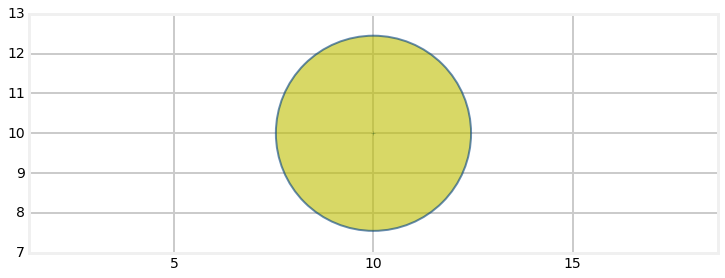

In [25]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)

Now suppose that there is a radar to the lower left of the aircraft. Further suppose that the radar is very accurate in the bearing measurement, but not very accurate at the range. That covariance, which is the uncertainty in the reading might look like this (plotted in blue):

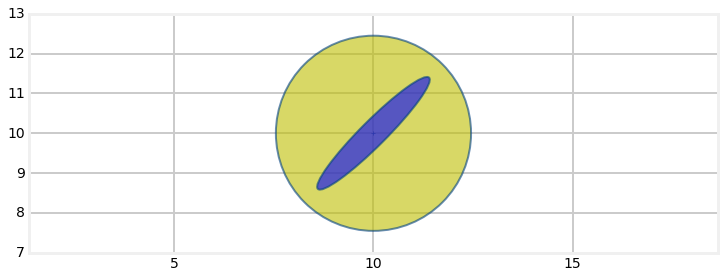

In [26]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)

Recall that Bayesian statistics calls this the *evidence*. The ellipse points towards the radar. It is very long because the range measurement is inaccurate, and the aircraft could be within a considerable distance of the measured range. It is very narrow because the bearing estimate is very accurate and thus the aircraft must be very close to the bearing estimate.

We want to find the *posterior* - the mean and covariance of incorporating the evidence into the prior. As in every chapter so far we multiply them together. I have the equations for this and we could use those, but I will use FilterPy's `multivariate_multiply` method.

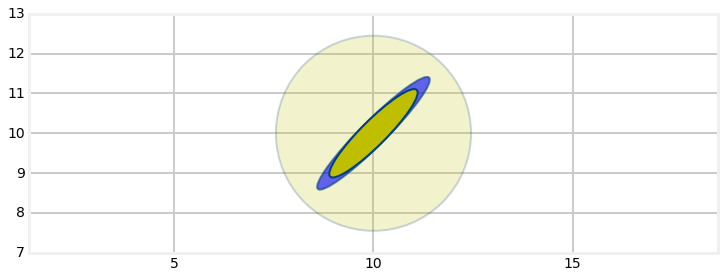

In [27]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, facecolor='y')

Here I have plotted the original estimate (prior) in a very transparent yellow, the radar reading in blue (evidence), and the finale estimate (posterior) in yellow.

The Gaussian retained the same shape and position as the radar measurement, but is smaller. We've seen this with one dimensional Gaussians. Multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain.  But the main point I want to make is that the covariance shape reflects the physical layout of the aircraft and the radar system.

Now lets say we get a measurement from a second radar, this one to the lower right, which I will plot in blue against the yellow covariance of our current belief. 

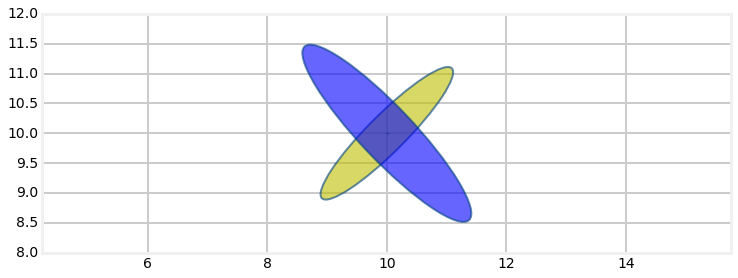

In [28]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)

Again, to incorporate this new information we will multiply the Gaussians together.

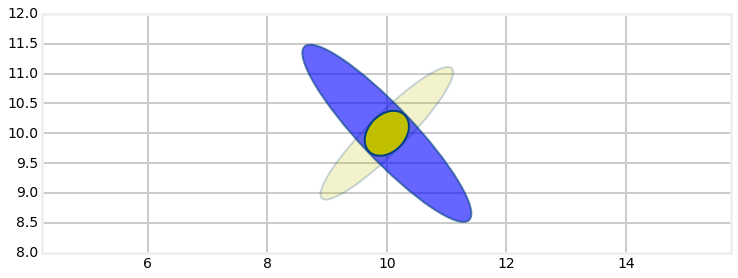

In [29]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, facecolor='y')

You can see how the multivariate Gaussian's shape reflects the geometry of the problem. The first radar system was at a 45 degree angle to the aircraft, and its error in the bearing measurement was much smaller than the error in the range. This resulted in a long and narrow covariance ellipse whose major axis was aligned with the angle to the radar system. The next radar system was also at a 45 degree angle, but to the right, so the two measurements were orthogonal to each other. This allowed us to *triangulate* on the aircraft, resulting in a very accurate estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

To make sure you understand this, what would the Gaussian look like if we only had one radar station, and we received several measurements from it over a short period of time? Clearly the Gaussian would remain elongated in the axis of the bearing angle. Without a second radar station no information would be provided to reduce the error on that axis, so it would remain quite large. As the aircraft moves the bearing will typically change by a small amount, so over time some of the error will be reduced, but it will never be reduced as much as a second radar station would provide.

To round this out lets quickly redo this example but with the first radar system in a different position. I will position it directly to the left of the aircraft. The only change I need to make is to the Gaussian for the measurement from the radar. In the previsous example I used

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

Why did this result in a 45 degree ellipse? Think about that before reading on. It was 45 degrees because the values in the diagonal were identical. So if x=10 then y=10, and so on. We can alter the angle by making the variance for x or y different, like so:

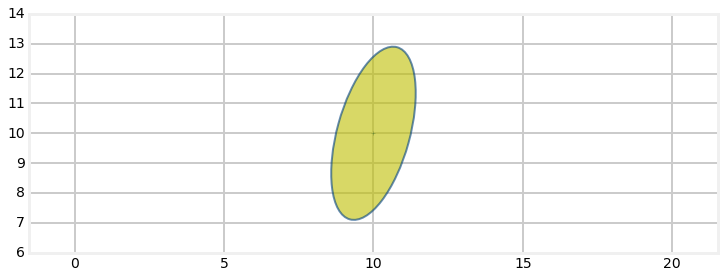

In [30]:
P1 = [[2, 1.9], [1.9, 8.4]]
plot_covariance_ellipse((10, 10), P1, facecolor='y', alpha=0.6)

The relationships can be hard to puzzle out by inspection, so here is an interactive plot. (If you are reading this in a static form instructions to run this online are here: http://git.io/vmv6e)

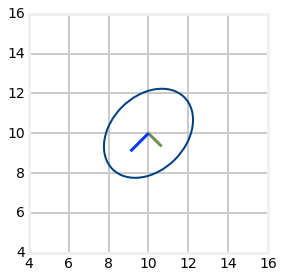

In [31]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets import FloatSlider

def plot_covariance(var_x, var_y, cov_xy):
    P1 = [[var_x, cov_xy], [cov_xy, var_y]]
    try:
        plot_covariance_ellipse((10, 10), P1, axis_equal=False,
                                show_semiaxis=True)
    except:
        plot_covariance_ellipse((10, 10), P1, axis_equal=False)
        
    plt.xlim(4, 16)
    plt.gca().set_aspect('equal')
    plt.ylim(4, 16)
    plt.show()

interact (plot_covariance,           
          var_x=FloatSlider(value=5., min=0, max=20.), 
          var_y=FloatSlider(value=5., min=0., max=20.), 
          cov_xy=FloatSlider(value=1.5, min=0.0, max=50, step=.2));

The radar is to the left of the aircraft, so I can use a covariance of 

$$\Sigma = \begin{bmatrix}2&0\\0&0.2\end{bmatrix}$$

to model the measurement. Incidentally, I invented those values. We haven't learned how to transform a matrix from one coordinate system to another. 

In the next graph I plot the original estimate in a very light yellow, the radar measurement in blue, and the new estimate based on multiplying the two Gaussians together in yellow.

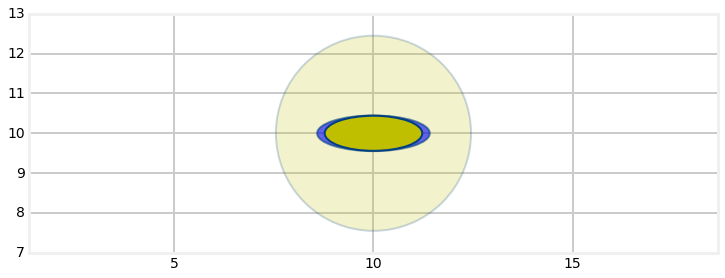

In [32]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, facecolor='y')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

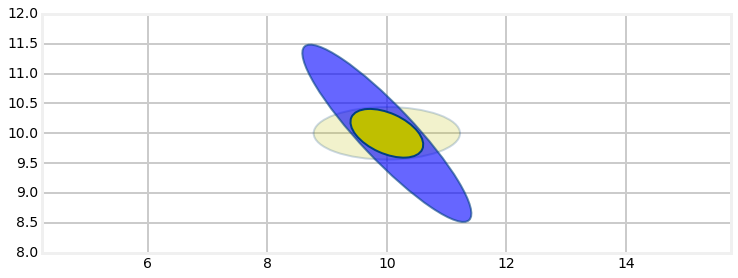

In [33]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, facecolor='y')

Our estimate is not as accurate as the previous example. The two radar stations are no longer orthogonal to each other relative to the aircraft's position so the triangulation is not optimal. Imagine standing on the ground and trying to triangulate on an aircraft in the sky with a transit. If you took a measurement, moved the transit 5 meters and took a second measurement the tiny change in angle between the two measurements would result in a very poor measurement because a very small error in either measurement would give a wildly different result. Think of the measurements as two nearly parallel lines. Changing the angle between them slightly will move the intersection between the two by a large amount. If you were to take the measurements from positions 100 km apart the lines might be nearly perpendicular to each other, in which case a small measurement error would result in a very small shift in the intersection point.

## Hidden Variables

You can probably already see why a multivariate Kalman filter can perform better than a univariate one. The last section demonstrated how we can use correlations between variables to significantly improve our estimates. We can take this much further. This section contains the key insight to this chapter, so read carefully.

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1,2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

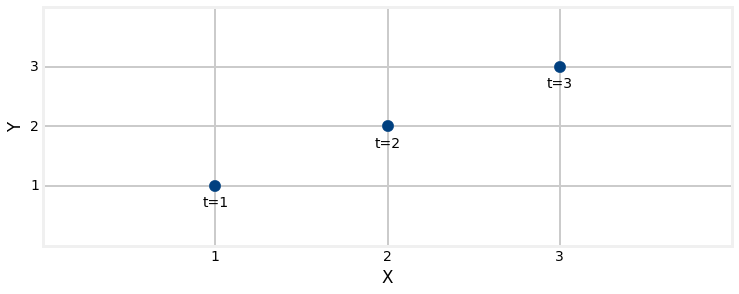

In [34]:
import mkf_internal
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

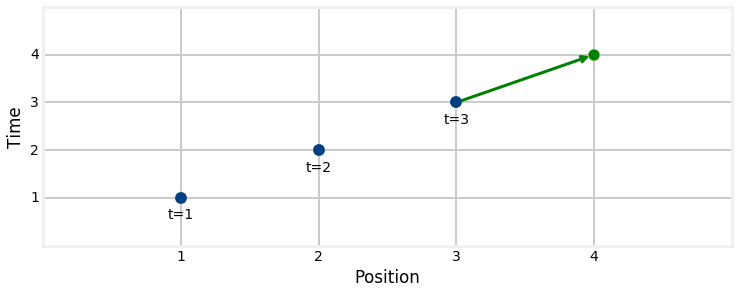

In [35]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The *reasonable* assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Think back to the g-h filter chapter when we were trying to improve the weight predictions of a noisy scale. We incorporated *weight gain* into the equations because it allowed us to make a better prediction of the weight the next day. The g-h filter uses the *g* parameter to scale the amount of significance given to the current weight measurement, and the *h* parameter scaled the amount of significance given to the weight gain.

We are going to do the same thing with our Kalman filter. After all, the Kalman filter is a form of a g-h filter. In this case we are tracking an airplane, so instead of weight and weight gain we need to track position and velocity. Weight gain is the *derivative* of weight, and of course velocity is the derivative of position. It's impossible to plot and understand the 4D chart that would be needed to plot *x* and *y* and their respective velocities so let's do it for $x$, knowing that the math generalizes to more dimensions.

At time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrow width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

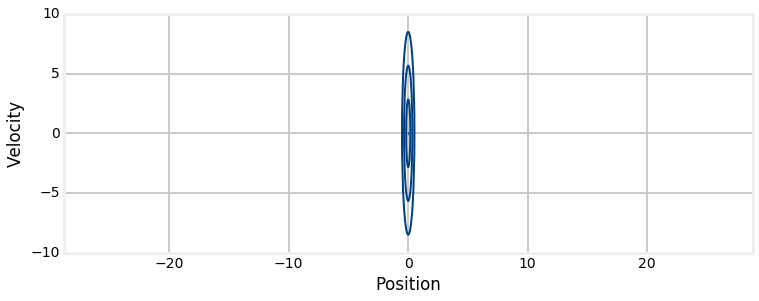

In [36]:
mkf_internal.show_x_error_chart(1)

Now after one second we get a position update of x=5.

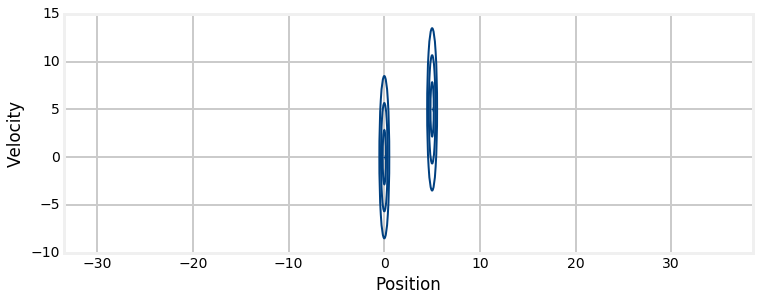

In [37]:
mkf_internal.show_x_error_chart(2)

This implies that our velocity is roughly 5 m/s. But of course position and velocity are correlated. If the velocity is 5 m/s the position would be 5, but if the velocity was 10 m/s the position would be 10. So let's draw a covariance matrix in red showing the relationship between the position and velocity.

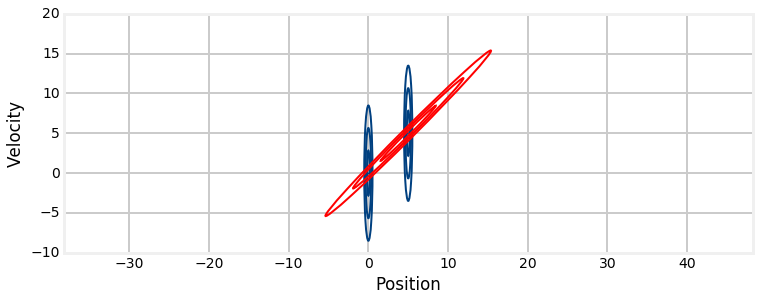

In [38]:
mkf_internal.show_x_error_chart(3)

It won't be clear until the next chapter how I calculate this covariance. Ignore the calculation, and think about what this implies. We have no easy way to say where the object really is because we are so uncertain about the velocity. Hence the ellipse stretches very far in the x-axis. Our uncertainty in velocity of course means it is also very spread in the y-axis. But as I said in the last paragraph, position and velocity is correlated. *If* the velocity is 5 m/s the next position would be 5, and *if* the velocity is 10 the next position would be 10. They are extremely correlated, so the ellipse must be very narrow. 

This superposition of the two covariances is where the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the *intersection* between the two covariance matrices! More exactly, we can use the math from the last section and *multiply* the two covariances together. From a Bayesian point of view we multiply the prior with the probability of the evidence (the *likelihood*) to get the posterior. If we multiply the position covariance with the velocity covariance using the Bayesian equations we get the result shown in the next chart.

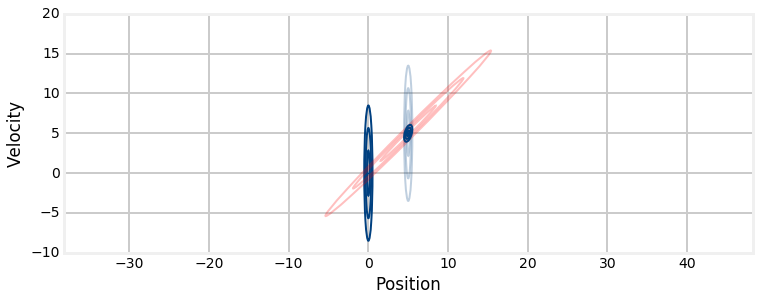

In [39]:
mkf_internal.show_x_error_chart(4)

We can see that the new covariance (the posterior) lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. Far more importantly, it is much smaller than either the position or velocity covariances. In the previous chapter our variance would get smaller each time we performed an `update()` because the previous estimate was multiplied by the new measurement. The same thing happens here. However, the amount by which the covariance got smaller by is much larger in this chapter. This is because we are using two different kinds of information which are nevertheless correlated. Knowing the velocity approximately and the position approximately allows us to very quickly hone in on the correct answer. 

This is a key point in Kalman filters, so read carefully! Our sensor is only detecting the position of the aircraft (how doesn't matter). This is called an *observed variable*. It does not have a sensor that provides velocity. But based on the position estimates we can compute velocity. In Kalman filters we would call the velocity a *hidden variable*. Hidden means what it sounds like - there is no sensor that is measuring velocity, thus its value is hidden from us. We are able to use the correlation between position and velocity to infer its value very accurately.

To round out the terminology there are also *unobserved variables*. For example, the aircraft's state includes things such as as heading, engine RPM, weight, color, the first name of the pilot, and so on. We cannot sense these directly using the position sensor so they are not *observed*. There is no way to *infer* them from the sensor measurements and correlations (red planes don't go faster than white planes), so they are not *hidden*. Instead, they are *unobservable*. If you include an unobserved variable in your filter state the estimate for that variable will be nonsense.

What makes this possible? Imagine for a moment that we superimposed the velocity from a different airplane over the position graph. Clearly the two are not related, and there is no way that combining the two could possibly yield any additional information. In contrast, the velocity of this airplane tells us something very important - the direction and speed of travel. So long as the aircraft does not alter its velocity the velocity allows us to predict where the next position is. After a relatively small amount of error in velocity the probability that it is a good match with the position is very small. Think about it - if you suddenly change direction your position is also going to change a lot. If the measurement of the position is not in the direction of the velocity change it is very unlikely to be true. The two are correlated, so if the velocity changes so must the position, and in a predictable way. 

It is important to understand that we are taking advantage of the fact that velocity and position are correlated. We get a rough estimate of velocity from the distance and time between two measurement, and use Bayes theorem to and produce very accurate estimates after only a few observations. Please reread this section if you have any doubts. If you do not understand this you will quickly find it impossible to reason about what you will learn in the following chapters.

In summary we have taken advantage of the geometry and correlations of the system to produce a very accurate estimate. The math does not care whether we are working with two positions, or a position and a correlated velocity, or if these are spatial dimensions. If floor space is correlated to house price you can write a Kalman filter to track house prices. If age is correlated to disease incidence you can write a Kalman filter to track diseases. If the zombie population is inversely correlated with the number of shotguns then you can write a Kalman filter to track zombies. I showed you this in terms of geometry and talked about *triangulation*. That was just to build your intuition. Get used to thinking of these as Gaussians with correlations. If we can express our uncertainties as a multidimensional Gaussian we can then multiply the prior with the likelihood and get a much more accurate result. 

## References

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy